In [1]:
%load_ext autoreload
%autoreload 2

# Deep Gaussian Markov Random Fields on graph (the Graph DGMRF model) on the Wikipedia example

The original article is [here](https://proceedings.mlr.press/v162/oskarsson22a/oskarsson22a.pdf) and the code can be found [here](https://github.com/joeloskarsson/graph-dgmrf/blob/main/utils.py).

The experiment consists in predicting unobserved node attributes (a real number) when the graph is known and the observed node attributes are known too.

The results of this notebook are to be compared with the Table 1 of the article. Our implmentation seems to perform better. We thus seem able to reasonably infer the unobserved node attributes.

In [2]:
from functools import partial
import jax
#jax.config.update('jax_platforms', "cpu")
import jax.numpy as jnp
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import optax
from jax_tqdm import scan_tqdm
import copy
import equinox as eqx
import numpy as np


key = jax.random.PRNGKey(0)

2024-07-05 16:32:13.224702: W external/xla/xla/service/gpu/nvptx_compiler.cc:765] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.5.40). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [3]:
try:
    gpu_device = jax.devices('gpu')[0]
    cpu_device = jax.devices('cpu')[0]
    print(cpu_device, gpu_device)
except:
    cpu_device = jax.devices('cpu')[0]
    print(cpu_device)

TFRT_CPU_0 cuda:0


## Load the wikipedia graph data for chameleon 🦎

**Note that it would be good to have a more rigorous preprocessing of the data: e.g. isolated nodes** (see [original code](https://github.com/joeloskarsson/graph-dgmrf/blob/4c640b3eba025fdfdec8db977ca0f484748737d1/data_loading/wiki.py#L41))

In [4]:
from dgmrf.utils import get_N_y_D_A
N, y, D, A = get_N_y_D_A("musae_chameleon")

As stated in the article, **50% of nodes will be unobserved**, randomly and uniformly chosen and optionally add noise

In [5]:
from dgmrf.utils import get_y_with_mask_and_noise
true_sigma_noise = 0.5
key, subkey = jax.random.split(key, 2)
y, mask = get_y_with_mask_and_noise(y, y.shape[0] // 2, subkey, true_sigma_noise)

## Define the DGMRF components

In [6]:
from dgmrf.models import DGMRF, MeanField, FactorizedS

In [7]:
L = 3
Nq = 5

In [8]:
y = y.flatten()
mask = mask.flatten()

In [9]:
key, subkey = jax.random.split(key, 2)

dgmrf = DGMRF(
    subkey,
    L,
    A_D=(A, D),
    log_det_method="eigenvalues",
    with_bias=True,
    non_linear=False,
)


Instanciate the variational distribution. The factorized distribution is much slower. MF variational distribution is already very satisfying.

In [10]:
key, subkey1, subkey2 = jax.random.split(key, 3)

q_phi = MeanField(N=N, key=subkey1)
# q_phi = FactorizedS(
#     N=N,
#     dgmrf_args=(subkey1, 1),
#     dgmrf_kwargs= {
#         "A_D":(A, D),
#         "log_det_method":"eigenvalues"
#     },
#     key=subkey2
# )

Define the Model equinox module `(DGMRF, VariationalDistribution, noise_parameter_array)`. This is just a container-like structure

In [11]:
from dgmrf.train import Model
model = Model(dgmrf, q_phi, jnp.log(true_sigma_noise))

## Variational inference to compute model parameters

In [12]:
n_iter = 25000
lr_graph = 1e-3

lr = lr_graph
tx = optax.multi_transform(
    {
     'dgmrf': optax.adam(lr), 'log_sigma': optax.adam(0), 'q_phi': optax.adam(lr)},
    Model(dgmrf="dgmrf", posterior="q_phi", noise_parameter="log_sigma")
)
opt_state = tx.init(eqx.filter(model, eqx.is_array))

In [13]:
from dgmrf.losses import dgmrf_elbo
from dgmrf.train import train_loop

print_rate = 5000
key, subkey = jax.random.split(key, 2)

model, loss_val, opt_state = train_loop(dgmrf_elbo, model, y, n_iter, tx, opt_state, subkey, print_rate, N, Nq, mask=mask)

Iteration 0, loss_value = -221343.125
Iteration 5000, loss_value = -235.99578857421875
Iteration 10000, loss_value = -40.814361572265625
Iteration 15000, loss_value = -6.8815131187438965
Iteration 20000, loss_value = 4.20373010635376
End of training (iteration 25000), loss_value = 7.5756402015686035


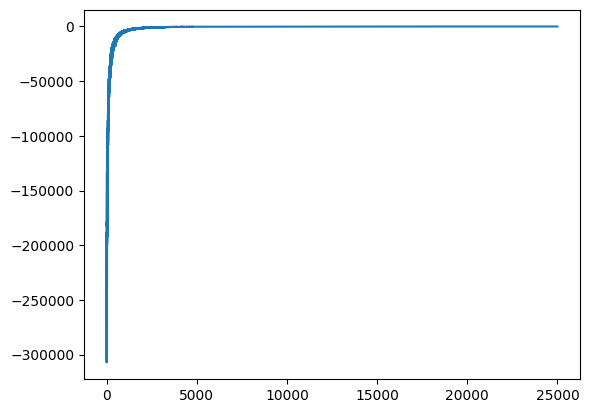

In [14]:
plt.plot((loss_val))
plt.show()

The means of the variational distribution will be the inferred values as a first approximation..

In [15]:
rmse_nu_phi = jnp.sqrt(jnp.mean((model.posterior.params["nu"] - y) ** 2))
print("RMSE with the means of the variational distribution", rmse_nu_phi)

RMSE with the means of the variational distribution 3.985897


**.. but the estimation is very bad with the variational posterior means !**

### Computation of posterior mean

In [16]:
mu_post_exact = model.dgmrf.get_post_mu(
    y,
    model.noise_parameter,
    mask=mask,
    method="exact"
)

In [17]:
rmse_mu_post_exact = jnp.sqrt(jnp.mean((mu_post_exact - y) ** 2))
print("RMSE with the exact posterior mean", rmse_mu_post_exact)

RMSE with the exact posterior mean 0.42862558


In [18]:
xpost_mean = model.dgmrf.get_post_mu(y, model.noise_parameter, model.posterior.params["nu"], mask=mask, method="cg");

In [19]:
rmse_xpost_mean = jnp.sqrt(jnp.mean((xpost_mean - y) ** 2))
print("RMSE with the posterior mean from conjugate gradient", rmse_xpost_mean)

RMSE with the posterior mean from conjugate gradient 0.4177313


**Now the results are much better using an exact computation of the posterior means or its approximation using a conjugate gradient algorithm ! We even do better than the results reported in the article, using only the MF approximation**

## Test on the squirrel wikipedia graph 🐿️

In [20]:
from dgmrf.utils import get_N_y_D_A
N, y, D, A = get_N_y_D_A("musae_squirrel")

In [21]:
key, subkey = jax.random.split(key, 2)
L = 3
Nq = 5
dgmrf = DGMRF(
    subkey,
    L,
    A_D=(A, D),
    log_det_method="eigenvalues",
    with_bias=True,
    non_linear=False,
)
key, subkey = jax.random.split(key)
q_phi = MeanField(N=N, key=subkey)
model = Model(dgmrf, q_phi, jnp.log(true_sigma_noise))
key, subkey = jax.random.split(key, 2)
y, mask = get_y_with_mask_and_noise(y, y.shape[0] // 2, subkey, true_sigma_noise)

In [22]:
n_iter = 50000
lr_graph = 1e-3

lr = lr_graph
tx = optax.multi_transform(
    {
     'dgmrf': optax.adam(lr), 'log_sigma': optax.adam(0), 'q_phi': optax.adam(lr)},
    Model(dgmrf="dgmrf", posterior="q_phi", noise_parameter="log_sigma")
)
opt_state = tx.init(eqx.filter(model, eqx.is_array))

In [23]:
from dgmrf.losses import dgmrf_elbo
from dgmrf.train import train_loop

print_rate = 5000
key, subkey = jax.random.split(key, 2)

model, loss_val, opt_state = train_loop(dgmrf_elbo, model, y, n_iter, tx, opt_state, subkey, print_rate, N, Nq, mask=mask)

Iteration 0, loss_value = -19465254.0
Iteration 5000, loss_value = -10491.22265625
Iteration 10000, loss_value = -914.7408447265625
Iteration 15000, loss_value = -100.9206314086914
Iteration 20000, loss_value = -21.759613037109375
Iteration 25000, loss_value = 0.05420875549316406
Iteration 30000, loss_value = 6.255952835083008
Iteration 35000, loss_value = 8.870471954345703
Iteration 40000, loss_value = 10.076672554016113
Iteration 45000, loss_value = 10.548379898071289
End of training (iteration 50000), loss_value = 10.90072250366211


In [24]:
rmse_nu_phi = jnp.sqrt(jnp.mean((model.posterior.params["nu"] - y) ** 2))
print("RMSE with the means of the variational distribution", rmse_nu_phi)
mu_post_exact = model.dgmrf.get_post_mu(
    y,
    model.noise_parameter,
    mask=mask,
    method="exact"
)
rmse_mu_post_exact = jnp.sqrt(jnp.mean((mu_post_exact - y) ** 2))
print("RMSE with the exact posterior mean", rmse_mu_post_exact)
xpost_mean = model.dgmrf.get_post_mu(y, model.noise_parameter, model.posterior.params["nu"], mask=mask, method="cg");
rmse_xpost_mean = jnp.sqrt(jnp.mean((xpost_mean - y) ** 2))
print("RMSE with the posterior mean from conjugate gradient", rmse_xpost_mean)

RMSE with the means of the variational distribution 6.4483366
RMSE with the exact posterior mean 0.8824542
RMSE with the posterior mean from conjugate gradient 0.88814384


**Same remark as before: the variational mean parameter cannot be taken for the inferred values (they represented a very bad approximation), however, our exact posterior mean computation as well as our approximate posterior mean computation (with conjugate gradient) yields very good results as compared as in the article**

## Test on the crocodile wikipedia graph 🐊

For large graph, eigenvalue decomposition is too costly, even if performed only once before. The approach to compute the log determinant is then the power series approach for this section

In [4]:
from dgmrf.utils import get_N_y_D_A
N, y, D, A = get_N_y_D_A("musae_crocodile")

/home/hugo/anaconda3/envs/dgmrf/lib/python3.11/site-packages/jax/experimental/sparse/coo.py:332: CuSparseEfficiencyWarning: coo_fromdense cusparse/hipsparse lowering not available for dtype=dtype('int8'). Falling back to default implementation.
  warnings.warn(f"coo_fromdense cusparse/hipsparse lowering not available for {dtype=}. "


In [ ]:
from dgmrf.models import DGMRF, MeanField, FactorizedS
from dgmrf.utils import get_y_with_mask_and_noise
L = 3
Nq = 5
key, subkey = jax.random.split(key, 2)
dgmrf = DGMRF(
    subkey,
    L,
    A_D=(A, D),
    log_det_method="power_series",
    with_bias=True,
    non_linear=False,
)
key, subkey = jax.random.split(key)
q_phi = MeanField(N=N, key=subkey)
model = Model(dgmrf, q_phi, jnp.log(true_sigma_noise))
key, subkey = jax.random.split(key, 2)
y, mask = get_y_with_mask_and_noise(y, y.shape[0] // 2, subkey, true_sigma_noise)

In [ ]:
n_iter = 50000
lr_graph = 1e-3

lr = lr_graph
tx = optax.multi_transform(
    {
     'dgmrf': optax.adam(lr), 'log_sigma': optax.adam(0), 'q_phi': optax.adam(lr)},
    Model(dgmrf="dgmrf", posterior="q_phi", noise_parameter="log_sigma")
)
opt_state = tx.init(eqx.filter(model, eqx.is_array))

In [ ]:
from dgmrf.losses import dgmrf_elbo
from dgmrf.train import train_loop

print_rate = 5000
key, subkey = jax.random.split(key, 2)

model, loss_val, opt_state = train_loop(dgmrf_elbo, model, y, n_iter, tx, opt_state, subkey, print_rate, N, Nq, mask=mask)

In [ ]:
rmse_nu_phi = jnp.sqrt(jnp.mean((model.posterior.params["nu"] - y) ** 2))
print("RMSE with the means of the variational distribution", rmse_nu_phi)
mu_post_exact = model.dgmrf.get_post_mu(
    y,
    model.noise_parameter,
    mask=mask,
    method="exact"
)
rmse_mu_post_exact = jnp.sqrt(jnp.mean((mu_post_exact - y) ** 2))
print("RMSE with the exact posterior mean", rmse_mu_post_exact)
xpost_mean = model.dgmrf.get_post_mu(y, model.noise_parameter, model.posterior.params["nu"], mask=mask, method="cg");
rmse_xpost_mean = jnp.sqrt(jnp.mean((xpost_mean - y) ** 2))
print("RMSE with the posterior mean from conjugate gradient", rmse_xpost_mean)